In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from textblob import TextBlob

## Reading in API Data

In [4]:
#Read in the df
df = pd.read_csv('comments_df.csv')

#Clean the df and drop some columns
df = df.drop(columns=['Unnamed: 0','author'])

print(df.head())

      video_id                                            comment  \
0  7MAJfcG8B7E  ⚡ ALL MY FAVOURITE TOOLS\nhttps://smartmoneywi...   
1  7MAJfcG8B7E  spare change is scam! i have spent 130£  witho...   
2  7MAJfcG8B7E  I just noticed I spent 280 Euros in the last 0...   
3  7MAJfcG8B7E  I thought why not, enabled the revpoint progra...   
4  7MAJfcG8B7E  Metal user here. Rev points are not a good dea...   

           published_at  
0  2024-07-18T16:22:20Z  
1  2024-10-30T02:41:59Z  
2  2024-10-30T00:34:43Z  
3  2024-10-26T12:29:17Z  
4  2024-10-21T10:49:10Z  


In [5]:
#Convert the published_at to date 
df['published_at']= df['published_at'].astype('datetime64[ns]')

In [6]:
df['month'] = df['published_at'].dt.month
df['year'] = df['published_at'].dt.year

## Basic EDA on the comments

In [7]:
print('Total Comments:', len(df['comment']))
print('Unique Videos:', len(df['video_id'].unique()))

Total Comments: 279
Unique Videos: 7


In [32]:
print('Comments per video id: ', 
      df['video_id'].value_counts())

Comments per video id:  TW__W5AGKEQ    62
p7PPpw55SZI    59
J5FLyHMV9og    53
gQscaDIRaMQ    49
7MAJfcG8B7E    25
p1Ni5ZuOVZ4    17
FiY2RY55YTg    14
Name: video_id, dtype: int64


In [8]:
# Set the timestamp as the index for resampling
df.set_index('published_at', inplace=True)
# Resample the data by month and count the comments per month
monthly_comments = df.resample('M').size()


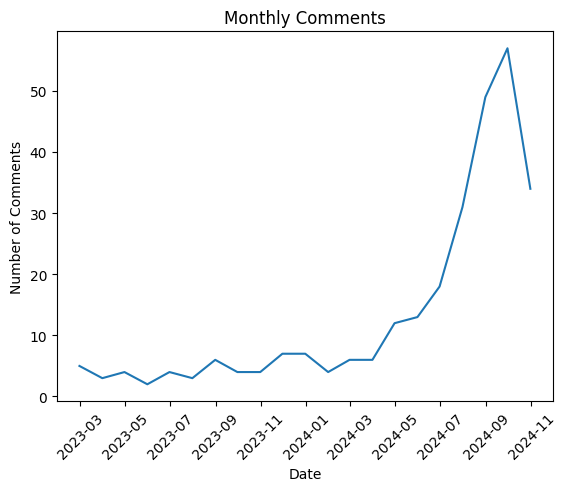

In [9]:
import matplotlib.pyplot as plt

plt.plot(monthly_comments.index, monthly_comments.values)
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.title('Monthly Comments')
plt.xticks(rotation=45)
plt.show()

## Sentiment Analysis

First using NLTK

In [39]:
polarity = []
for i in df['comment']:
    blob = TextBlob(i)
    polarity.append(round(blob.sentiment.polarity,3))
df['polarity'] = polarity
print('Polarity Column added to the dataframe')

Polarity Column added to the dataframe


In [40]:
sentiment = []
for i in df['polarity']:
    if i > 0:
        sentiment.append('positive')
    elif i < 0:
        sentiment.append('negative')
    else:
        sentiment.append('neutral')

df['sentiment'] = sentiment

In [42]:
df.head()

,video_id,comment,month,year,polarity,sentiment,score
published_at,,,,,,,
2024-07-18 16:22:20,7MAJfcG8B7E,⚡ ALL MY FAVOURITE TOOLS\nhttps://smartmoneywi...,7,2024,0.214,positive,0.8151
2024-10-30 02:41:59,7MAJfcG8B7E,spare change is scam! i have spent 130£ witho...,10,2024,0.100,positive,0.8992
2024-10-30 00:34:43,7MAJfcG8B7E,I just noticed I spent 280 Euros in the last 0...,10,2024,-0.135,negative,0.9208
2024-10-26 12:29:17,7MAJfcG8B7E,"I thought why not, enabled the revpoint progra...",10,2024,0.167,positive,0.8270
2024-10-21 10:49:10,7MAJfcG8B7E,Metal user here. Rev points are not a good dea...,10,2024,0.075,positive,0.8661


In [43]:
print('Reviews with Positive Sentiment based on Polarity :', len(df[df['polarity'] > 0]))
print('Reviews with Negative Sentiment based on Polarity :', len(df[df['polarity'] < 0]))
print('Reviews with Neutral Sentiment based on Polarity :', len(df[df['polarity'] == 0]))

Reviews with Positive Sentiment based on Polarity : 133
Reviews with Negative Sentiment based on Polarity : 38
Reviews with Neutral Sentiment based on Polarity : 108


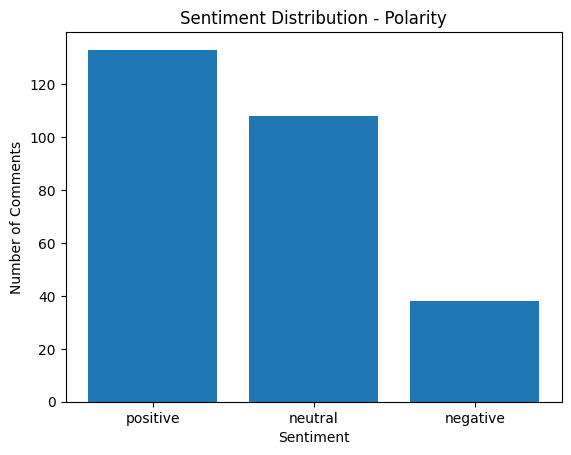

In [44]:
#Distribution of Polarity
plt.bar(df['sentiment'].value_counts().index, df['sentiment'].value_counts().values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution - Polarity')
plt.show()

Now using LLMs(Transformers)

### 1. Twitter roBERTa 
This is a roBERTa-base model trained on ~124M tweets and finetuned for sentiment analysis with the TweetEval benchmark. 

In [46]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax


def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#model.save_pretrained(MODEL)
text = "I have been with REVOLUT now since covid, since they asked me to give them a new 6 figure pass number from the old 4 number pass number, nothing like causing massive  problems , I beginning  to hate this online banking app Once I use up my current balance  I will close this account as I do not like stress and trouble I would never recommend  this app to anyone ,bad news"
text = preprocess(text)

encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)


ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


/Users/lukegorman/opt/anaconda3/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you e

1) negative 0.9299
2) neutral 0.0618
3) positive 0.0083


In [47]:
# Build a function to iteratre though the comments and get the sentiment
def get_sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    
    for i in range(scores.shape[0]):
        l = config.id2label[ranking[i]]
        s = scores[ranking[i]]
        return l, np.round(float(s), 4)
    
df['sentiment'], df['score'] = zip(*df['comment'].map(get_sentiment))


In [48]:
print('Reviews with Positive Sentiment based on roBERTa :', len(df[df['sentiment'] == 'positive']))
print('Reviews with Negative Sentiment based on roBERTa :', len(df[df['sentiment'] == 'negative']))
print('Reviews with Neutral Sentiment based on roBERTa :', len(df[df['sentiment'] == 'neutral']))


Reviews with Positive Sentiment based on roBERTa : 54
Reviews with Negative Sentiment based on roBERTa : 89
Reviews with Neutral Sentiment based on roBERTa : 136


In [49]:
df.head()


,video_id,comment,month,year,polarity,sentiment,score
published_at,,,,,,,
2024-07-18 16:22:20,7MAJfcG8B7E,⚡ ALL MY FAVOURITE TOOLS\nhttps://smartmoneywi...,7,2024,0.214,positive,0.8151
2024-10-30 02:41:59,7MAJfcG8B7E,spare change is scam! i have spent 130£ witho...,10,2024,0.100,negative,0.8992
2024-10-30 00:34:43,7MAJfcG8B7E,I just noticed I spent 280 Euros in the last 0...,10,2024,-0.135,negative,0.9208
2024-10-26 12:29:17,7MAJfcG8B7E,"I thought why not, enabled the revpoint progra...",10,2024,0.167,positive,0.8270
2024-10-21 10:49:10,7MAJfcG8B7E,Metal user here. Rev points are not a good dea...,10,2024,0.075,negative,0.8661


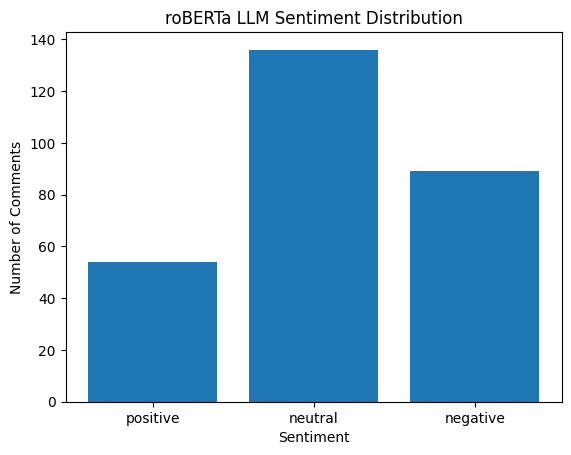

In [50]:
# Get the value counts in the specified order
sentiment_counts = df['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'])

# Plot the bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('roBERTa LLM Sentiment Distribution')
plt.show()